In [31]:
import numpy as np
from scipy.special import eval_hermite
from scipy.linalg import qr
from dppy.finite_dpps import FiniteDPP

# Set random seed for reproducibility
seed = 0
rng = np.random.RandomState(seed)

# Step 1: Define the number of samples we want and candidate points
N = 100  # Number of points we want to sample
M = N * 3  # Number of candidate points (should be > N)
d = 2
mean = np.zeros(d)  # Mean of the Gaussian distribution
cov = np.eye(d)  # Covariance matrix of the Gaussian distribution

# Step 2: Generate M candidate points from a Gaussian distribution
X = rng.multivariate_normal(mean.flatten(), cov, size=M)  # Gaussian sample

# Step 3: Compute Hermite polynomials at these candidate points
Phi = np.zeros((M, N))  # M rows (candidates), N columns (features)

k_max = int(np.sqrt(N))
hermite_indices = [(k1, k2) for k1 in range(k_max) for k2 in range(k_max)]

for i, (k1, k2) in enumerate(hermite_indices[:N]):  # Limit to N features
    Phi[:, i] = eval_hermite(k1, X[:, 0]) * eval_hermite(k2, X[:, 1])

# Step 4: Perform QR decomposition to get an orthonormal basis
eig_vecs, _ = qr(Phi, mode='economic')  # Gives an MxN orthonormal matrix

# Step 5: Construct Projection DPP
DPP = FiniteDPP(kernel_type='correlation', projection=True,
                **{'K_eig_dec': (np.ones(N), eig_vecs)})  # All eigenvalues = 1

# Step 6: Sample exactly N points from the Projection DPP
DPP.sample_exact(mode='GS', random_state=rng)

# Get sampled indices and corresponding points
selected_indices = DPP.list_of_samples[0]  # Get the first sampled subset
dpp_samples = X[selected_indices]  # Extract exactly N sampled points

print("Selected samples from Gaussian DPP with Hermite polynomials:")
print(dpp_samples.mean(axis=0))  # Should be close to 0
print(dpp_samples.std(axis=0))  # Should be close to 1


Selected samples from Gaussian DPP with Hermite polynomials:
[-0.02835983 -0.03343683]
[1.40392133 1.35928677]


In [45]:
len(selected_indices)

100

In [39]:
DPP.compute_K()
print("K =\n", DPP.K)

K =
 [[ 6.43764958e-01  1.06055243e-04  2.22446908e-03 ...  1.56158687e-02
   3.49349162e-03 -5.53532130e-03]
 [ 1.06055243e-04  9.99996962e-01  1.87524942e-05 ... -1.75974203e-05
  -4.08002519e-05  2.94113307e-05]
 [ 2.22446908e-03  1.87524942e-05  9.99168254e-01 ...  4.93819691e-04
   5.60027943e-04 -7.40694027e-04]
 ...
 [ 1.56158687e-02 -1.75974203e-05  4.93819691e-04 ...  6.44888322e-02
  -1.27014547e-03  4.16604541e-04]
 [ 3.49349162e-03 -4.08002519e-05  5.60027943e-04 ... -1.27014547e-03
   4.33097897e-02  9.68166772e-03]
 [-5.53532130e-03  2.94113307e-05 -7.40694027e-04 ...  4.16604541e-04
   9.68166772e-03  8.96074495e-02]]


In [46]:
np.diag(DPP.K[[selected_indices], [selected_indices]])


array([0.67615778])

In [22]:
import os
import sys
os.chdir('/home/zongchen/mmd_flow_cubature/')
sys.path.append('/home/zongchen/mmd_flow_cubature/')
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
jax.config.update("jax_platform_name", "cpu")

from mmd_flow.distributions import Distribution
from mmd_flow.kernels import gaussian_kernel
from mmd_flow.mmd import mmd_fixed_target
from mmd_flow.gradient_flow import gradient_flow

Text(0.5, 1.0, 'DPP samples')

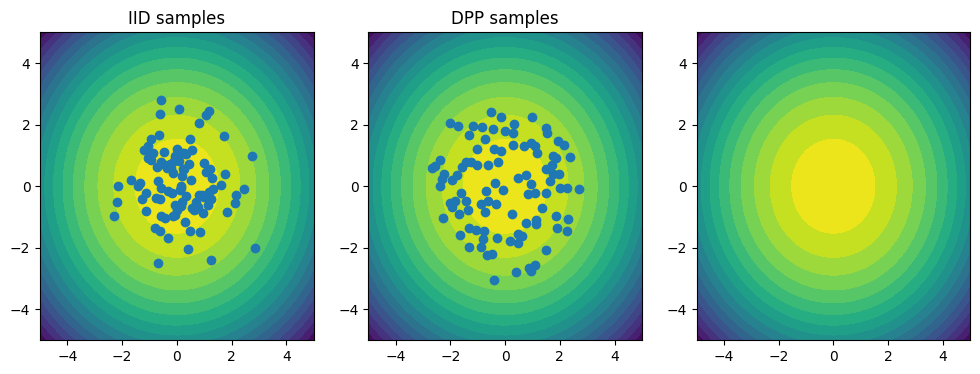

In [23]:
kernel = gaussian_kernel(1.0)
k = 2
means = jnp.zeros([k, d])
covariances = jnp.array([jnp.eye(d) for _ in range(k)])
weights = jnp.ones(k) / k
distribution = Distribution(kernel=kernel, means=means, covariances=covariances, integrand_name='neg_exp', weights=weights)
rng_key = jax.random.PRNGKey(0)
iid_samples = distribution.sample(N, rng_key)

x_range = (-5, 5)
y_range = (-5, 5)
resolution = 100
x_vals = np.linspace(x_range[0], x_range[1], resolution)
y_vals = np.linspace(y_range[0], y_range[1], resolution)
X, Y = np.meshgrid(x_vals, y_vals)
grid = np.stack([X.ravel(), Y.ravel()], axis=1)
logpdf = np.log(distribution.pdf(grid).reshape(resolution, resolution))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
contour = axs[0].contourf(X, Y, logpdf, levels=20, cmap='viridis')
contour = axs[1].contourf(X, Y, logpdf, levels=20, cmap='viridis')
contour = axs[2].contourf(X, Y, logpdf, levels=20, cmap='viridis')

axs[0].scatter(iid_samples[:, 0], iid_samples[:, 1], label='iid samples')
axs[0].set_title('IID samples')
axs[1].scatter(dpp_samples[:, 0], dpp_samples[:, 1], label='qmc samples')
axs[1].set_title('DPP samples')